In [27]:
from varyingsim.algos.BufferedModel import BufferedModel
from varyingsim.envs.push_box_circle import PushBoxCircle, sin_com_slow
from varyingsim.models.mujoco_dynamics import MuJoCoDynamics
from varyingsim.datasets.fov_dataset import SmoothFovDataset, SmoothFovDatasetGenerator
from varyingsim.util.learn import learn_every_k_single

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

import pickle

In [17]:
env = PushBoxCircle()

N = 100
T = 3000
d_obs = env.model.nq + env.model.nv
d_in = d_obs + env.model.nu

In [18]:
cur_act = np.array([0.0, 0])
def act_fn(obs, i, t):
    global cur_act # TODO: is there a better way?
    if t == 0: # new episode! new control!
        cur_act = np.array([0.1 + np.random.rand() * 0.7, np.random.rand() * 2 * np.pi])
    return cur_act

# location = '/data/varyingsim/push_box_circle.pickle'
location = "D:\\data\\varyingsim\\push_box_circle.pickle"
gen = SmoothFovDatasetGenerator(location,  PushBoxCircle, sin_com_slow, act_fn, N, T)

In [19]:
dataset = SmoothFovDataset(location, 1)

In [20]:
dataset[1]

{'context_obs': array([[0. , 0. , 0.1, 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. ]]),
 'context_act': array([[0.15598918, 2.00756947]]),
 'obs': array([-9.80585197e-23, -1.53509041e-22,  9.99967587e-02,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.15462437e-01,
         1.81082934e-01, -2.89161407e-19, -4.52677547e-19, -4.90387740e-03,
         5.01305787e-18, -3.20224159e-18, -1.39973793e-34,  6.59861933e-02,
        -1.41345137e-01]),
 'act': array([0.15598918, 2.00756947]),
 'fov': array([4.18879017e-05, 1.50000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00]),
 'obs_prime': array([-3.89022412e-22,  2.34378668e-11,  9.99919410e-02,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.15528423e-01,
         1.80941589e-01, -2.93263601e-19,  4.62093750e-08, -4.73260981e-03,
        -5.09095718e-07, -3.16005771e-18,  3.19844162e-20,  6.59861933e-02,
        -1.41345137e-01]),


In [25]:
def run(buffer_size=1, learn_freq=1, lr=1e-3, d_hidden=64):
    model = nn.Sequential(
        nn.Linear(d_in, d_hidden),
        nn.ReLU(),
        nn.Linear(d_hidden, d_hidden),
        nn.ReLU(),
        nn.Linear(d_hidden, d_obs)
    )

    mujoco_model = MuJoCoDynamics(env, model)
    optim = torch.optim.SGD(mujoco_model.parameters(), lr=lr)

    algo = BufferedModel(buffer_size, env, mujoco_model, optim, mujoco_model.delta_layer.mse_loss)

    info = learn_every_k_single(algo, dataset, learn_freq, print_iter=1500)

    return {'algo': algo, 'mujoco_model': model, 'algo': algo, 'info': info}

In [26]:
# varying buffer size exp
# TODO: vary learn_freq with buffer_sizer size?
infos = []
for buffer_size in [1, 256, 2000, 4000]:
    info = run(buffer_size=buffer_size)
    info['buffer_size'] = buffer_size
    infos.append(info)

0 0.10641541332006454 0.0990869402885437
1500 0.0013841595500707626 0.0013543397653847933
3000 0.014745531603693962 0.0012809832114726305
4500 0.0011670921230688691 0.0008719855104573071
6000 0.04020035266876221 0.002886404050514102
7500 0.0009319364908151329 0.0009110379032790661
9000 0.044476915150880814 0.002698499010875821
10500 0.005092634353786707 0.00506863696500659
12000 0.040187522768974304 0.0023116464726626873
13500 0.00042767246486619115 0.0004264551098458469
15000 0.061208248138427734 0.0037930046673864126
16500 0.0016210429603233933 0.001069982536137104
18000 0.034366171807050705 0.00442491052672267
19500 0.0001746480556903407 0.00017417674825992435
21000 0.010680180974304676 0.0007072375738061965
22500 0.00010028893302660435 3.551162080839276e-05
24000 0.028763659298419952 0.013257546350359917
25500 0.0010837458539754152 0.0010808669030666351
27000 0.035252396017313004 0.0037350996863096952
28500 0.0006148467073217034 0.0006136587471701205
30000 0.0186587143689394 0.0011

244500 0.0001233196962857619 0.00012916428386233747
246000 0.01256383303552866 0.00012831318599637598
247500 0.00016460379993077368 0.00015545969654340297
249000 0.02121010236442089 0.00020199456776026636
250500 0.0019621937535703182 0.001906293909996748
252000 0.040596432983875275 0.0005975198582746089
253500 0.00022955119493417442 0.00022982156951911747
255000 0.028245674446225166 0.00040788165642879903
256500 0.0004623843415174633 0.00029018192435614765
258000 0.02737775631248951 0.0006833065417595208
259500 6.31646835245192e-05 6.324426794890314e-05
261000 0.020370176061987877 0.00011829927825601771
262500 1.7466009012423456e-05 1.7436439520679414e-05
264000 0.0008137007826007903 0.00017827221017796546
265500 3.8547692383872345e-05 2.588013740023598e-05
267000 0.01043313555419445 0.0002905908040702343
268500 7.812057447154075e-06 6.5943622757913545e-06
270000 0.017919696867465973 3.191059659002349e-05
271500 0.0006331853801384568 5.220758248469792e-05
273000 0.02493804693222046 0.0

186000 7.731004734523594e-05 0.0002733739383984357
187500 3.137611201964319e-05 3.8552996556973085e-05
189000 5.2131374104646966e-05 0.00037516633165068924
190500 5.118321496411227e-05 5.238690209807828e-05
192000 7.244777953019366e-05 0.0005941493436694145
193500 0.0005799481878057122 9.570644760970026e-05
195000 6.57718483125791e-05 0.0005917762173339725
196500 0.0009486653143540025 8.051696931943297e-05
198000 2.7233190849074163e-05 0.00026098961825482547
199500 4.895563324680552e-05 4.5457069063559175e-05
201000 0.00022915206500329077 0.00021231747814454138
202500 0.0002754793385975063 4.8444831918459386e-05
204000 3.3059128327295184e-05 0.00012719571532215923
205500 5.86998721701093e-05 4.6318949898704886e-05
207000 0.0003168031107634306 0.0004986792919225991
208500 0.0004415428265929222 0.00011383843229850754
210000 0.00010545125405769795 0.0001643868745304644
211500 0.00022870345856063068 2.764947566902265e-05
213000 0.0003430142533034086 0.00010923348600044847
214500 0.00047967

127500 0.0007574972696602345 0.00045811873860657215
129000 0.00039128956268541515 0.0005608900100924075
130500 0.0003770850016735494 0.0002509199548512697
132000 0.00022423478367272764 1.0005657713918481e-05
133500 0.00012504075129982084 1.5521149180131033e-05
135000 0.0001454168523196131 0.0001286188344238326
136500 0.00034979262272827327 6.584188668057323e-05
138000 0.00044981788960285485 0.00021931725495960563
139500 0.00039854005444794893 0.00010067037510452792
141000 9.587813838152215e-05 0.00015845200687181205
142500 0.0001781937462510541 0.00013023927749600261
144000 8.096825331449509e-05 5.673599662259221e-05
145500 0.0009495076956227422 0.0004962459206581116
147000 0.00036093679955229163 0.00018142593035008758
148500 0.00032759716850705445 9.181463974528015e-05
150000 0.00025504943914711475 0.00011910654575331137
151500 0.00060250487877056 0.00041893182788044214
153000 0.0003170265699736774 0.0003046248748432845
154500 0.0005772008444182575 0.00019804906332865357
156000 0.0001

69000 0.00037219608202576637 0.0011632879031822085
70500 0.0008385309483855963 0.001179212937131524
72000 0.0012597882887348533 0.0005755426827818155
73500 0.0005999047425575554 0.0006377291865646839
75000 0.0003718095540534705 0.0002330699353478849
76500 0.0006605106755159795 0.0005654995911754668
78000 0.0007050724234431982 0.0004378818266559392
79500 0.0005679197493009269 0.0005793634336441755
81000 0.0006234842585399747 0.00046907205251045525
82500 0.0004880054038949311 0.0005724983057007194
84000 0.0003455840633250773 0.0012641180073842406
85500 0.00047283738967962563 0.0007141898386180401
87000 0.00033252433058805764 0.00032468768768012524
88500 0.0005691575934179127 0.0009309020824730396
90000 0.0004697987751569599 0.00020039125229232013
91500 0.0002725392405409366 0.0001631158374948427
93000 0.00017801104695536196 0.00038273222162388265
94500 0.0004044792731292546 0.000363644037861377
96000 0.0004511172592174262 7.414922583848238e-05
97500 0.00021985327475704253 0.0001631706691

In [28]:
with open('infos.pickle', 'wb') as f:
    pickle.dump(infos, f)

In [29]:
all_trains = []
all_tests = []
buf_sizes = []

for run_info in infos:
    info = run_info['info']
    train_losses = info['train_losses']
    test_losses = info['test_losses']
    buffer_size = run_info['buffer_size']
    all_trains.append(train_losses)
    all_tests.append(test_losses)
    buf_sizes.append(buffer_size)

In [31]:
%matplotlib widget
start_idx = 0

plt.title('train loss')
for i, train_loss in enumerate(all_trains):
    plt.plot(train_loss[start_idx:], label=buf_sizes[i])
    plt.legend()
plt.show()
    
plt.title('test loss')
for i, test_loss in enumerate(all_tests):
    plt.plot(test_loss[start_idx:], label=buf_sizes[i])
    plt.legend()
plt.show()
    

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

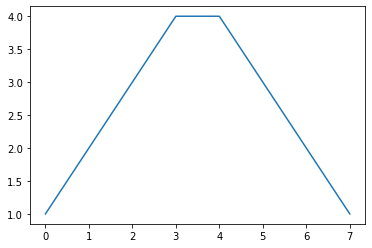

In [10]:
# %matplotlib widget
plt.plot([1,2,3,4,4,3,2,1])
plt.show()

In [11]:
i = 0
for _ in dataset:
    i+=1

In [12]:
i

1000

In [13]:
dataset.N

1000

In [14]:
dataset[4001]

IndexError: idx must be less than length!

In [ ]:
dataset[2001]

In [ ]:
dataset[6000]